In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.io import fits
import scipy
import pymaster as nmt

In [3]:
f0, f1 = '143', '143'
split0, split1 = '1', '2'
lmax = 1997
lmax_beam = 6500 # beam needs to extend to high enough ell for NaMaster
nside = 2048

In [16]:
# beam_filename = f'planck_beam/beam_{f0}hm1x{f1}hm2.dat'
# beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl

beam = fits.open('planck_beam/BeamWf_HFI_R3.01/Wl_R3.01_fullsky_143hm1x143hm2.fits')[1].data[0][0]

Bl = np.zeros(lmax_beam)
Bl[:len(beam)] = np.sqrt(beam)

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


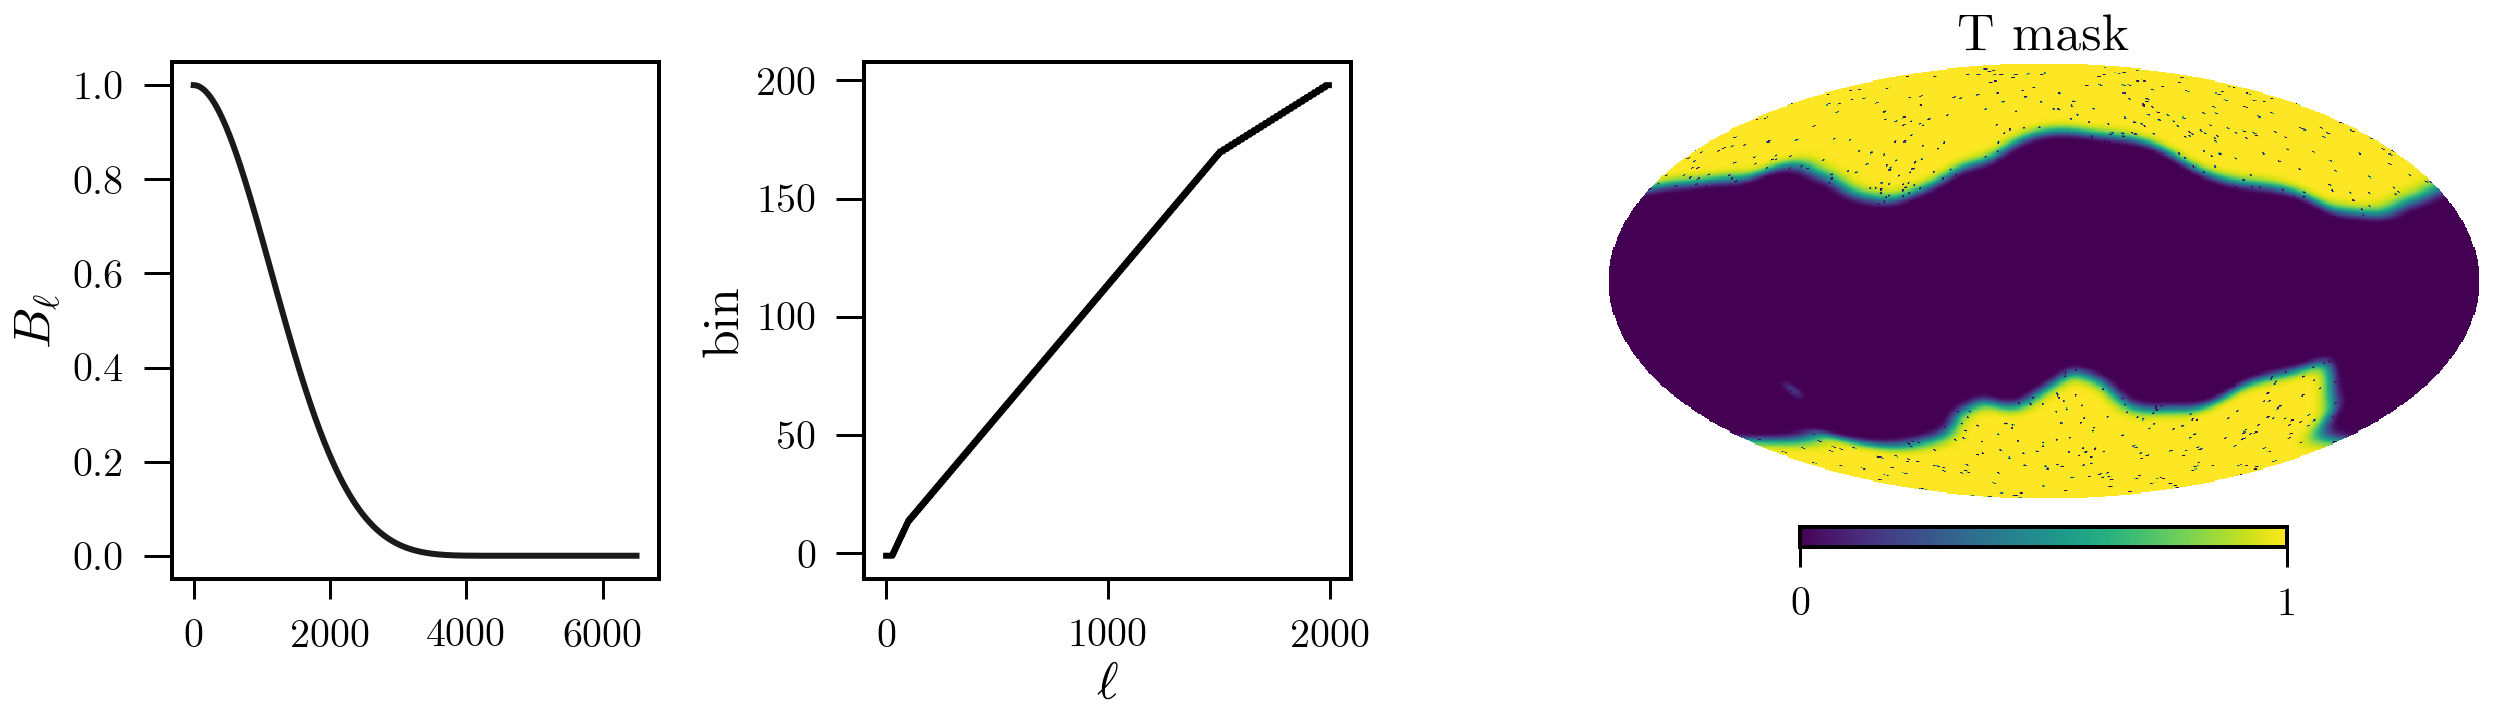

In [66]:


binleft, binright = np.genfromtxt('planck_spectra/binused.dat', 
                                  unpack=True, usecols=(0,1), dtype=((int), (int)))
ells = np.arange(lmax)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
weights = np.array([ 1 for l in range(lmax)])
b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=True)
lb = b.get_effective_ells()

# mask0 = hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f0}_2048_R2.00.fits', verbose=False)
# mask1 = hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f1}_2048_R2.00.fits', verbose=False)

gal_mask_040 = hp.read_map(f'masks/diy/HFI_Mask_GalPlane-apo2_2048_R2.00.fits', field=1)
point_source_mask = hp.read_map('masks/diy/HFI_Mask_PointSrc_2048_R2.00.fits')
badpixmap0 = (~badpix0[0]).astype(float) 
badpixmap1 = (~badpix1[0]).astype(float) 
mask0 =  gal_mask_040 * point_source_mask.data * badpixmap0
mask1 =  gal_mask_040 * point_source_mask.data * badpixmap1

mask0 = nmt.mask_apodization( mask0, 20/60, apotype="C1")
mask1 = nmt.mask_apodization( mask1, 20/60, apotype="C1")


                    
fig, ax = plt.subplots(1, 3, figsize=(18,5), gridspec_kw = {'width_ratios':[1, 1, 2]})
ax[0].plot( np.arange(lmax_beam), Bl)
ax[0].set_ylabel(r"$B_{\ell}$")
ax[1].plot(bpws, 'k-')
ax[1].set_ylabel('bin')
ax[1].set_xlabel(r'$\ell$')
fig.tight_layout()

plt.sca(ax[2])
hp.mollview(mask0, hold=True, title='T mask')

In [67]:
# m0_file = f'maps/PR3/frequencyMaps/HFI_SkyMap_{f0}_2048_R3.01_halfmission-{split0}.fits'
# m1_file = f'maps/PR3/frequencyMaps/HFI_SkyMap_{f1}_2048_R3.01_halfmission-{split1}.fits'

m0_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f0}_2048_R2.02_halfmission-{split0}.fits'
m1_file = f'maps/PR2/frequencyMaps/HFI_SkyMap_{f1}_2048_R2.02_halfmission-{split1}.fits'

map0 = [hp.read_map(m0_file, field=0, verbose=False), # I
        hp.read_map(m0_file, field=1, verbose=False), # Q
        hp.read_map(m0_file, field=2, verbose=False)] # U
map1 = [hp.read_map(m1_file, field=0, verbose=False), # I
        hp.read_map(m1_file, field=1, verbose=False), # Q
        hp.read_map(m1_file, field=2, verbose=False)] # U

In [68]:
badpix0 = [(m < -1e30) for m in map0]
badpix1 = [(m < -1e30) for m in map1]

map0 = [ (~bp).astype(float) * m for m, bp in zip(map0, badpix0) ]
map1 = [ (~bp).astype(float) * m for m, bp in zip(map1, badpix1) ]

In [69]:
pixel_window = hp.sphtfunc.pixwin(nside, pol=False)[:lmax_beam]

In [70]:
# NaMaster-CAR only supports niter=0
i0 = nmt.NmtField(mask0,[map0[0]], beam=(Bl*pixel_window), n_iter=3)
i1 = nmt.NmtField(mask1,[map1[0]], beam=(Bl*pixel_window), n_iter=3)
cl_00 = nmt.compute_full_master(i0,i1,b)
ell = b.get_effective_ells()

(0, 100)

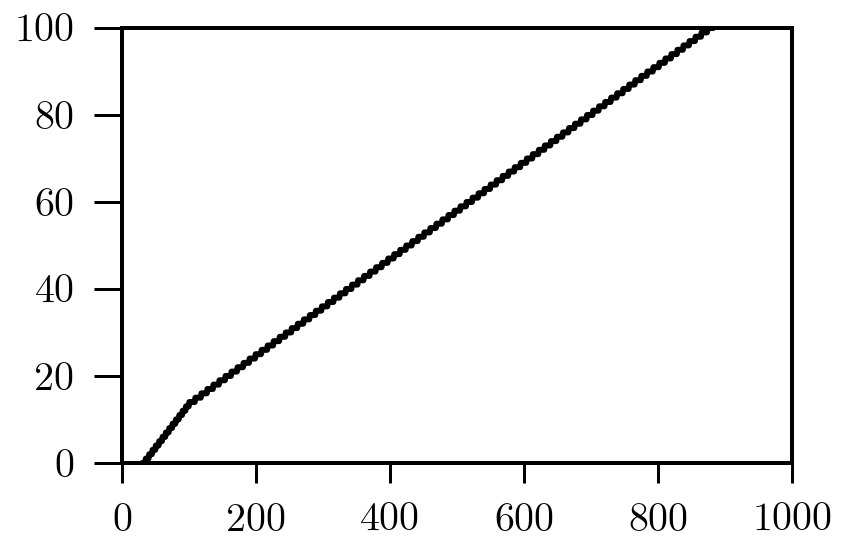

In [71]:
plt.plot(bpws, 'k-')
plt.xlim(0,1000)
plt.ylim(0,100)

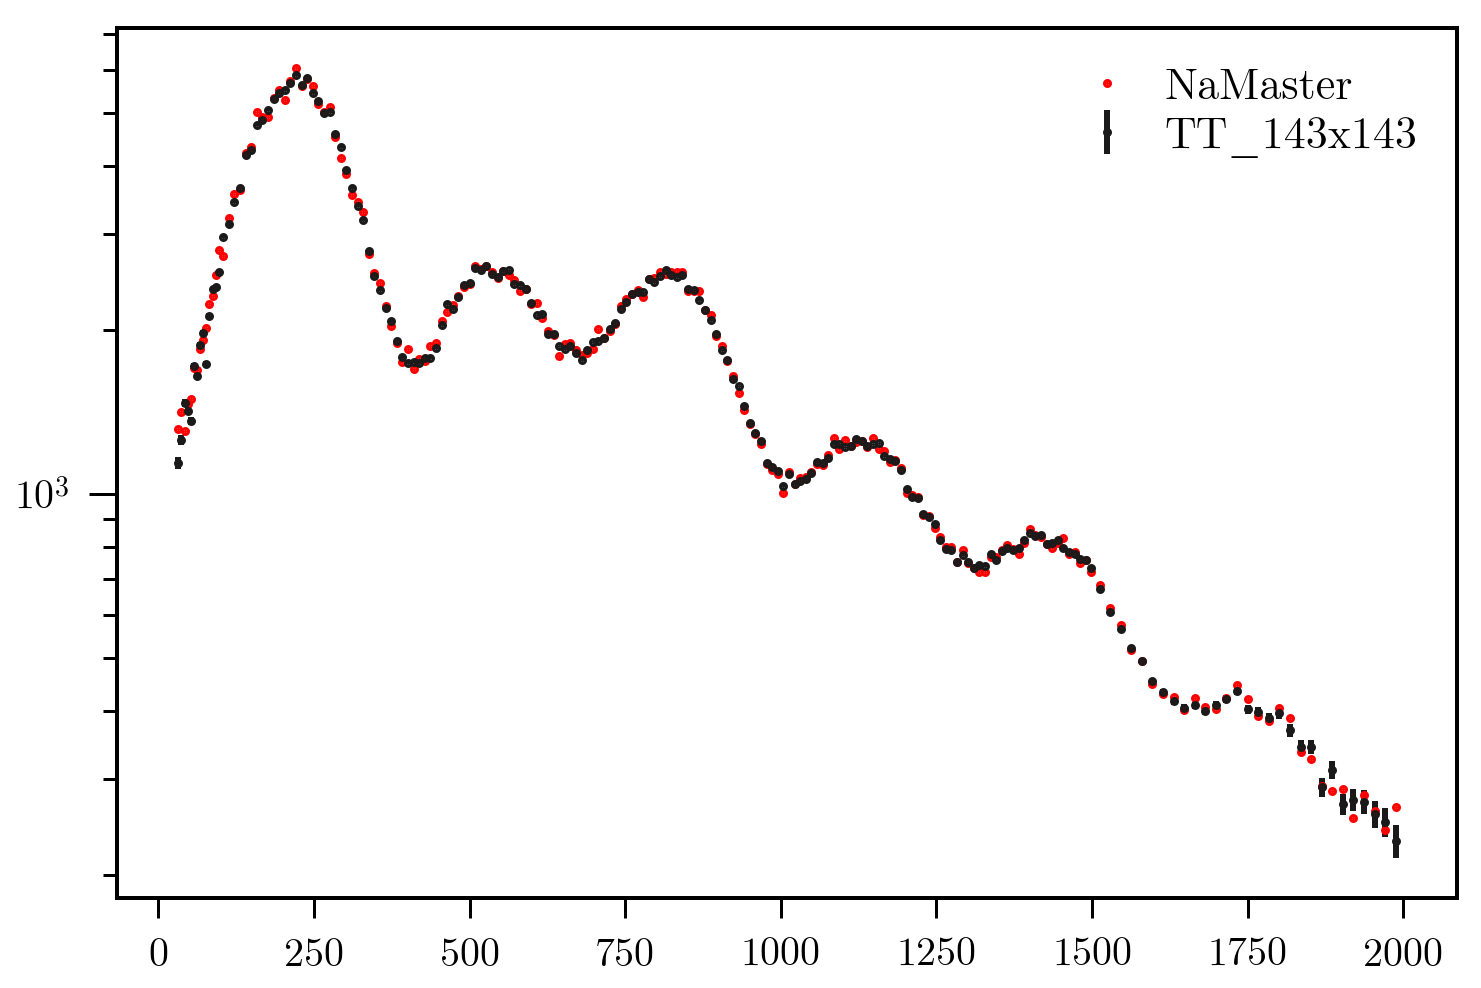

In [72]:
plt.figure(figsize=(12,8))
lmin_,lmax_,l,cl,error=np.loadtxt('planck_spectra/spectra_' + 'TT_143x143' + '.dat',unpack=True)
plt.errorbar(l,cl*l*(l+1)/(2*np.pi),error*l*(l+1)/(2*np.pi),fmt='.',label='%s'%'TT_143x143')
plt.plot(ell, cl_00[0] *  1e6**2  ,'r.',label=r"NaMaster")

plt.legend()
plt.yscale('log')

(10, 500)

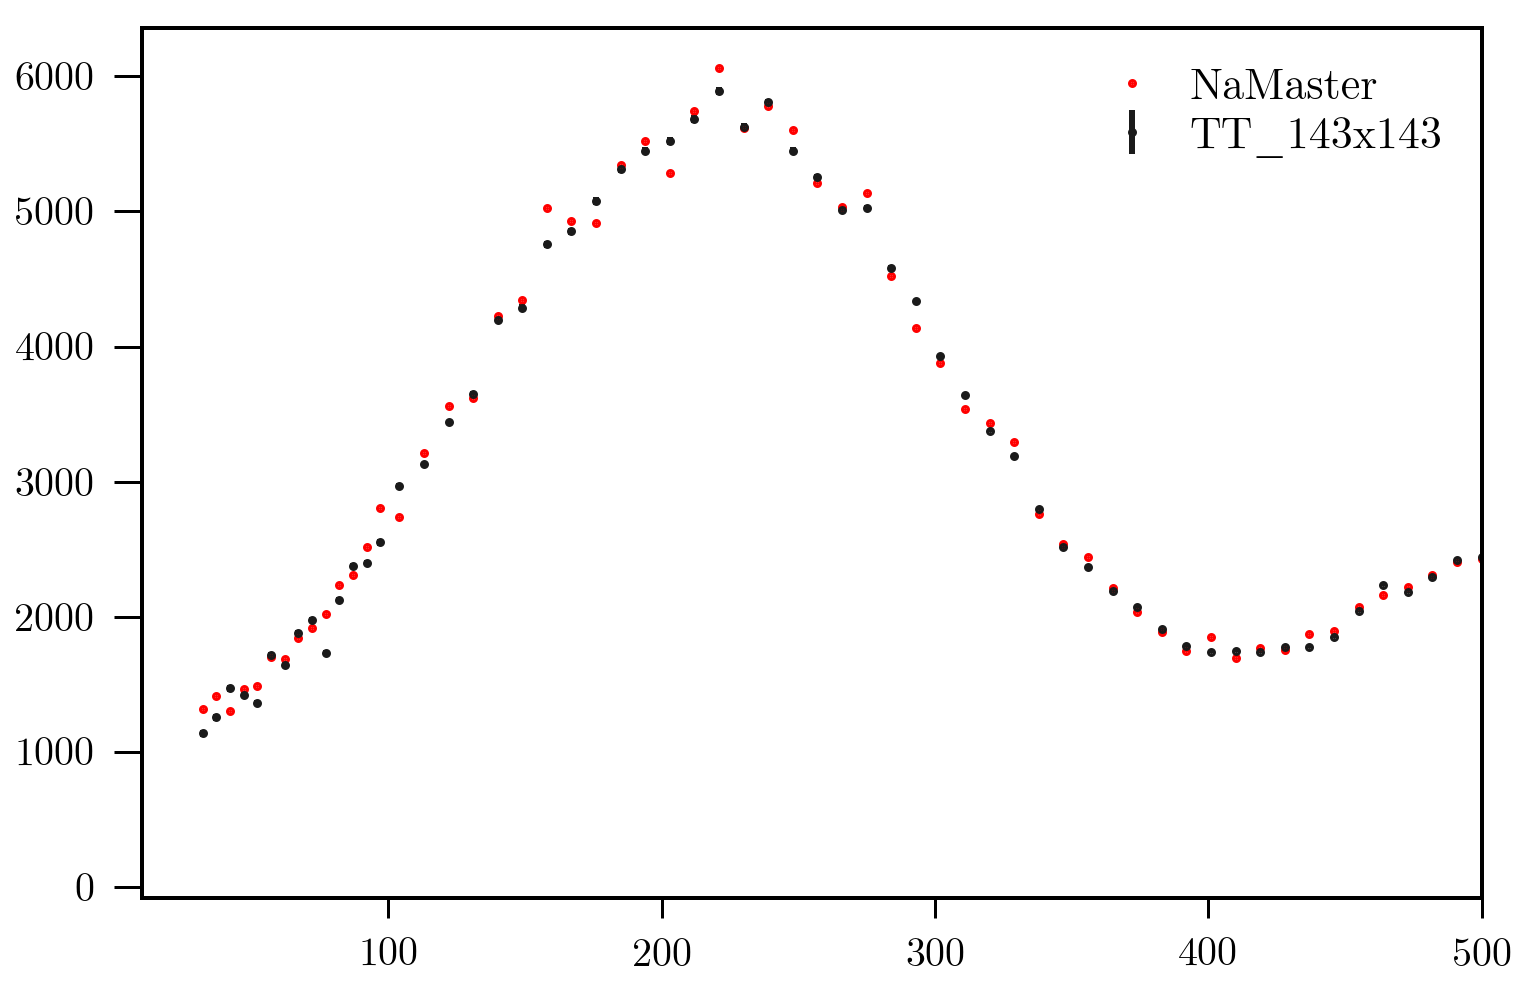

In [73]:
plt.figure(figsize=(12,8))
lmin_,lmax_,l,cl,error=np.loadtxt('planck_spectra/spectra_' + 'TT_143x143' + '.dat',unpack=True)
plt.errorbar(l,cl*l*(l+1)/(2*np.pi),error*l*(l+1)/(2*np.pi),fmt='.',label='%s'%'TT_143x143')
plt.plot(ell, cl_00[0] *  1e6**2 ,'r.',label=r"NaMaster")

plt.legend()
plt.xlim(10,500)

(0.98, 1.02)

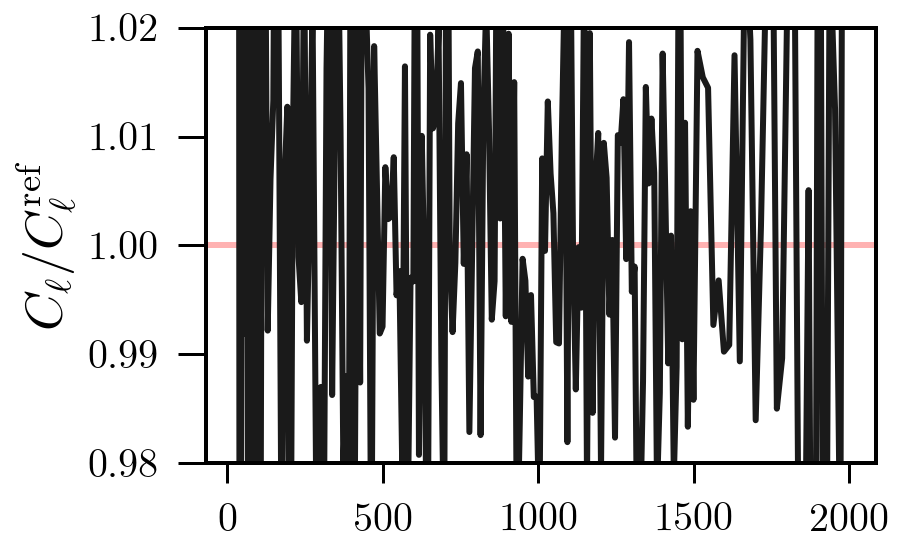

In [76]:
plt.axhline(1, color='red', alpha=0.3)
plt.plot( l, cl_00[0][:199] *  1e6**2 / (cl*(l)*(l+1)/(2*np.pi)))
plt.ylabel(r'$C_{\ell} / C_{\ell}^{\mathrm{ref}}$')
plt.ylim(0.98,1.02)